# Table of Contents
* [Dependency](#de)
* [Setting models / onnx files](#se)
* [Summary & speed graph](#su)

Results
1. [raw pytorch + cpu](#rcpu)
2. [onnx + static + cpu](#onnxs)
3. [onnx + dynamic + cpu](#onnxd)
4. [onnx + static + cpp +cpu](#coca)
5. [outputs comparison](#out)



# <a name="su">Summary</a>
1. There's no difference among outputs of raw pytorch models, static/dynamic onnx models and cpp api models. (e-10)

2. Speed comparison graph 
    * The static onnx inference is the fastest, approximately 2x at the most compared to the raw pytorch inference

/home/luhsuanwen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


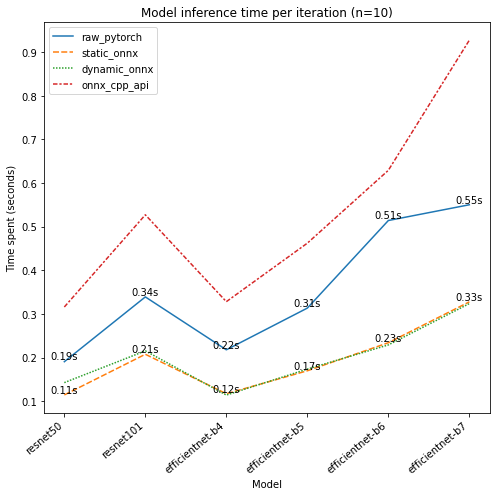

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.DataFrame(time_spent)
#plotting columns
plt.figure(figsize=(7, 7))
ax = sns.lineplot(data=df)
ax.set_xticklabels([0]+df["name"].to_list(), rotation=40, ha="right")
ax.set_title("Model inference time per iteration (n=10)")
ax.set_xlabel("Model")
ax.set_ylabel("Time spent (seconds)")
plt.tight_layout()
for i in df.index:
    raw_value = df.loc[i, "raw_pytorch"]
    static_value = df.loc[i, "static_onnx"]
    plt.annotate(f"{raw_value:.2f}s", (i, raw_value), ha="center", va="bottom")
    plt.annotate(f"{static_value:.2f}s", (i, static_value), ha="center", va="bottom")


# <a name="de">Dependency

In [1]:
# install onnx / onnxruntim / efficientnet first
import onnxruntime
import torch
import torch.nn as nn
from torchvision import models
import os
import numpy as np
import cv2
import time
from efficientnet_pytorch import EfficientNet

In [2]:
def pytorch_to_onnx(model, model_path, input_shape=(1, 3, 224, 224), opset_version=11):        
    input_data = torch.randn(input_shape)
    torch.onnx.export(model.eval(), input_data, model_path, opset_version=opset_version)
    print('Export Finished, now Checking ONNX Model')    
    get_and_check_onnx_model(model_path)

def pytorch_to_onnx_dynamic(model, model_path, input_shape=(1, 3, 224, 224), opset_version=11):        
    input_data = torch.randn(input_shape)
    input_name = "input.1"
    output_name = "output"
    input_names = [input_name]
    output_names = [output_name]
    dynamic_axes = {input_name: {2:'width', 3:'height'}, output_name : {1:'classes'}}
    torch.onnx.export(model, input_data, model_path, input_names=input_names, output_names=output_names, dynamic_axes=dynamic_axes, opset_version=opset_version)
    print('Export Finished, now Checking ONNX Model')    
    get_and_check_onnx_model(model_path)

def time_calculator(func):
    def wrap(*args, **kwargs):
        start = time.time()
        func(*args, **kwargs)
        end = time.time()
        time_spend = end - start
        print('time_spend: ', time_spend)
        return time_spend
    return wrap
    
def get_and_check_onnx_model(model_path):
    import onnx
    onnx_model = onnx.load(model_path)
    onnx.checker.check_model(onnx_model)
    print('if nothing showed, then the model is fine.')
    return onnx_model

def set_efficient_model_ready(model):
    model.set_swish(memory_efficient=False)
    return model


def _calculate_dhdw_half(h, w):
    """Calculate difference of h or w in order to get a square """
    if h > w:
        dh_half = int(0.1*h/2)
        dw_half = int((h+2*dh_half-w)/2)
    else:
        dw_half = int(0.1*w/2)
        dh_half = int((w+2*dw_half-h)/2)
    return dh_half, dw_half
    
def preprocess_onnx(image):
    # 加邊框
    h, w, c = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dh_half, dw_half = _calculate_dhdw_half(h, w)
    image = cv2.copyMakeBorder(image, dh_half, dh_half, dw_half, dw_half, cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (248, 248))[12:236, 12:236]/255.0
    image = image.transpose(2, 0, 1).astype(np.float32)[np.newaxis,:]
    return image

def preprocess_pt(image):
    # 加邊框
    h, w, c = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    dh_half, dw_half = _calculate_dhdw_half(h, w)
    image = cv2.copyMakeBorder(image, dh_half, dh_half, dw_half, dw_half, cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (248, 248))[12:236, 12:236]
    tensor = torch.tensor(image, dtype=torch.float)    
    return tensor.permute(2, 0, 1).div(255.0).unsqueeze(0)

def show_onnx_session_io_name(session):
    session.get_modelmeta()
    first_input_name = session.get_inputs()[0].name
    first_output_name = session.get_outputs()[0].name
    print(first_input_name, first_output_name)
    
def onnxruntime_inference(image, ort_session):
    image = preprocess_onnx(image)
    ort_inputs = {ort_session.get_inputs()[0].name: image}
    ort_outs = ort_session.run(None, ort_inputs)
    return ort_outs

# <a name="se">Setting models / onnx files

In [3]:
ROOT = "/home/luhsuanwen/project/"
model_name_list = ["resnet50", "resnet101", "efficientnet-b4", "efficientnet-b5", "efficientnet-b6", "efficientnet-b7"]
time_spent = {"name": model_name_list, "raw_pytorch": [], "static_onnx": [], "dynamic_onnx": [], "onnx_cpp_api": []}
model_path_list = []
dynamic_model_path_list = []
model_list = []
class_num = 801
for name in model_name_list:
    if name.startswith("res"):
        model = getattr(models, name)(pretrained=True)
        num_input_fts = model.fc.in_features
        model.fc = nn.Linear(num_input_fts, class_num)
        torch.manual_seed(0)
        w = torch.randn(class_num, num_input_fts)
        b = torch.randn(class_num)
        model.fc.bias.data = b
        model.fc.weight.data = w
    else:
        model = EfficientNet.from_pretrained(name)
        model = set_efficient_model_ready(model)
        num_input_fts = model._fc.in_features
        model._fc = nn.Linear(num_input_fts, class_num)
        torch.manual_seed(0)        
        w = torch.randn(class_num, num_input_fts)
        b = torch.randn(class_num)
        model._fc.bias.data = b
        model._fc.weight.data = w
    print(name, ": partial weights: \n  ", w[0][:5], "\n")
    model_path = ROOT + "ONNX_MODELS/" + name + ".onnx"
    dynamic_model_path = ROOT + "ONNX_MODELS/" + name + "_dynamic.onnx"
    model_path_list.append(model_path)
    dynamic_model_path_list.append(dynamic_model_path)
    model_list.append(model)
    if not os.path.exists(model_path):
        pytorch_to_onnx(model.eval(), model_path, opset_version=10)
    if not os.path.exists(dynamic_model_path):
        pytorch_to_onnx_dynamic(model.eval(), dynamic_model_path, opset_version=10)

resnet50 : partial weights: 
   tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.8487]) 

resnet101 : partial weights: 
   tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.8487]) 

Loaded pretrained weights for efficientnet-b4
efficientnet-b4 : partial weights: 
   tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.8487]) 

Loaded pretrained weights for efficientnet-b5
efficientnet-b5 : partial weights: 
   tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.8487]) 

Loaded pretrained weights for efficientnet-b6
efficientnet-b6 : partial weights: 
   tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.8487]) 

Loaded pretrained weights for efficientnet-b7
efficientnet-b7 : partial weights: 
   tensor([-1.1258, -1.1524, -0.2506, -0.4339,  0.8487]) 



# <a name="rcpu">Raw Pytorch Speed


In [4]:
n = 10
raw_outputs = []
for name, model in zip(model_name_list, model_list):
    model.cpu()
    model.eval() 
    start = time.time()
    for _ in range(n):
        test_image = cv2.imread(ROOT + "sample.jpg")
        tensor = preprocess_pt(test_image)
        output = model(tensor.cpu())        
        score, pred = torch.max(output, dim=1)
    end = time.time()
    raw_outputs.append(output)
    time_cost = (end-start)/n
    print(name, time_cost)
    time_spent["raw_pytorch"].append(time_cost)

/home/luhsuanwen/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


resnet50 0.19066495895385743
resnet101 0.33907380104064944
efficientnet-b4 0.2178569555282593
efficientnet-b5 0.31345367431640625
efficientnet-b6 0.5140809297561646
efficientnet-b7 0.5501985549926758


# <a name="onnxs">Onnx Static Speed

In [40]:
onnx_outputs = []
time_spent["static_onnx"] = []
n = 10
for name, model_path in zip(model_name_list, model_path_list):
    
    session = onnxruntime.InferenceSession(model_path)
#     show_onnx_session_io_name(session)
    start = time.time()
    for _ in range(n):
        test_image = cv2.imread(ROOT + "sample.jpg")
        outputs = onnxruntime_inference(test_image, session)
    end = time.time()
    onnx_outputs.append(outputs)
    time_cost = (end-start)/n
    print(name, os.path.basename(model_path), time_cost)
    time_spent["static_onnx"].append(time_cost)

resnet50 resnet50.onnx 0.11449034214019775
resnet101 resnet101.onnx 0.20764050483703614
efficientnet-b4 efficientnet-b4.onnx 0.11721885204315186
efficientnet-b5 efficientnet-b5.onnx 0.1698531150817871
efficientnet-b6 efficientnet-b6.onnx 0.23409552574157716
efficientnet-b7 efficientnet-b7.onnx 0.3277843952178955


# <a name="onnxd">Onnx Dynamic Speed

In [6]:
onnx_dynamic_outputs = []
n = 10
for name, model_path in zip(model_name_list, dynamic_model_path_list):    
    session = onnxruntime.InferenceSession(model_path)
#     show_onnx_session_io_name(session)
    start = time.time()
    for _ in range(n):
        test_image = cv2.imread(ROOT + "sample.jpg")
        outputs = onnxruntime_inference(test_image, session)
    end = time.time()
    onnx_dynamic_outputs.append(outputs)
    time_cost = (end-start)/n
    print(name, os.path.basename(model_path), time_cost)
    time_spent["dynamic_onnx"].append(time_cost)

resnet50 resnet50_dynamic.onnx 0.1427051067352295
resnet101 resnet101_dynamic.onnx 0.2154667854309082
efficientnet-b4 efficientnet-b4_dynamic.onnx 0.11418678760528564
efficientnet-b5 efficientnet-b5_dynamic.onnx 0.173706316947937
efficientnet-b6 efficientnet-b6_dynamic.onnx 0.22910447120666505
efficientnet-b7 efficientnet-b7_dynamic.onnx 0.32376704216003416


# <a name="coca">Onnx Static Cpp Api Speed

In [10]:
import ctypes
from numpy.ctypeslib import ndpointer
so_path = "/home/luhsuanwen/project/DeepLearningModelDeployment/onnxruntime/python_cpp_extension/libonnxpy.so"
onnx_cpp_outputs = []
time_spent["onnx_cpp_api"] = []
n = 10
for name in model_name_list:    
    model_path = ROOT + "ONNX_MODELS/" + name + ".onnx"
    image_path = ROOT + "sample.jpg"
    modelPath = model_path.encode(encoding="utf-8")
    imagePath = image_path.encode(encoding="utf-8")    

    dll = ctypes.cdll.LoadLibrary(so_path)
    dll.onnx_inference.restype = ctypes.POINTER(ctypes.c_float)
    dll.onnx_inference.restype = ndpointer(dtype=ctypes.c_float, shape=(801,))
    dll.onnx_inference.argtypes = [ctypes.c_char_p, ctypes.c_char_p]
    start = time.time()
    for _ in range(n):
        outputs_np = dll.onnx_inference(modelPath, imagePath)
    end = time.time()
    onnx_cpp_outputs.append(outputs_np)
    time_cost = (end-start)/n
    print(name, os.path.basename(model_path), time_cost)
    time_spent["onnx_cpp_api"].append(time_cost)


resnet50 resnet50.onnx 0.31598451137542727
resnet101 resnet101.onnx 0.5271782875061035
efficientnet-b4 efficientnet-b4.onnx 0.32816970348358154
efficientnet-b5 efficientnet-b5.onnx 0.46221585273742677
efficientnet-b6 efficientnet-b6.onnx 0.6291061878204346
efficientnet-b7 efficientnet-b7.onnx 0.9273323059082031


# <a name="out">Output Comparison

In [13]:
def postprocess_onnx(onnx_outputs):
    return onnx_outputs[0][0]

def postprocess_pt_cpu(pt_outputs):
    return pt_outputs.detach().numpy()[0]

In [14]:
for name, raw, onnx_, onnx_d, onnx_cpp in zip(model_name_list, raw_outputs, onnx_outputs, onnx_dynamic_outputs, onnx_cpp_outputs):
    raw = postprocess_pt_cpu(raw)
    onnx_ = postprocess_onnx(onnx_)
    onnx_d = postprocess_onnx(onnx_d)
    mse_raw_onnx_static = np.mean((raw - onnx_)**2)
    mse_raw_onnx_dynamic = np.mean((raw - onnx_d)**2)
    mse_raw_onnx_cpp = np.mean((raw - onnx_cpp)**2)
    print(name, ", mse: ", mse_raw_onnx_static, mse_raw_onnx_dynamic, mse_raw_onnx_cpp)

resnet50 , mse:  7.369016e-10 7.369016e-10 6.8453554e-10
resnet101 , mse:  3.8520462e-10 3.8520462e-10 4.556885e-10
efficientnet-b4 , mse:  3.3588207e-10 3.075183e-10 3.0715983e-10
efficientnet-b5 , mse:  4.901697e-10 5.8958294e-10 1.1123681e-10
efficientnet-b6 , mse:  3.3645428e-10 3.665344e-10 6.8501246e-11
efficientnet-b7 , mse:  9.3104985e-10 9.935979e-10 7.0258743e-10
